BatchNorm from scratch (forward & backward)

In [1]:
import numpy as np

class BatchNorm:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
        """
        Initialize BatchNorm layer.

        Parameters:
            input_dim (int): The number of features (input dimension).
            epsilon (float): A small constant to avoid division by zero.
            momentum (float): Momentum for moving average of mean and variance.
        """
        self.epsilon = epsilon
        self.momentum = momentum

        # Initialize gamma and beta for scaling and shifting
        self.gamma = np.ones(input_dim)
        self.beta = np.zeros(input_dim)

        # Initialize moving averages for mean and variance
        self.running_mean = np.zeros(input_dim)
        self.running_var = np.ones(input_dim)

        # For backpropagation
        self.cache = None

    def forward(self, X, training=True):
        """
        Forward pass of Batch Normalization

        Parameters:
            X (ndarray): Input data of shape (batch_size, input_dim).
            training (bool): Flag to determine whether in training or inference mode.

        Returns:
            out (ndarray): Output after Batch Normalization.
        """
        # Get the batch size and input dimension
        batch_size, input_dim = X.shape

        # Compute mean and variance in the batch
        if training:
            mean = np.mean(X, axis=0)
            var = np.var(X, axis=0)

            # Normalize the batch
            X_hat = (X - mean) / np.sqrt(var + self.epsilon)

            # Scale and shift
            out = self.gamma * X_hat + self.beta

            # Save values for backprop
            self.cache = (X, mean, var, X_hat)

            # Update the running mean and variance (for inference)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var

        else:
            # In inference mode, use running mean and variance
            X_hat = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_hat + self.beta

        return out

    def backward(self, dout):
        """
        Backward pass for Batch Normalization.

        Parameters:
            dout (ndarray): Upstream gradient from the next layer.

        Returns:
            dX (ndarray): Gradient with respect to the input X.
            dgamma (ndarray): Gradient with respect to gamma.
            dbeta (ndarray): Gradient with respect to beta.
        """
        X, mean, var, X_hat = self.cache
        batch_size = X.shape[0]

        # Gradient with respect to gamma and beta
        dgamma = np.sum(dout * X_hat, axis=0)
        dbeta = np.sum(dout, axis=0)

        # Gradient with respect to normalized output X_hat
        dX_hat = dout * self.gamma

        # Backpropagate through normalization
        dvar = np.sum(dX_hat * (X - mean) * -0.5 * np.power(var + self.epsilon, -1.5), axis=0)
        dmean = np.sum(dX_hat * -1.0 / np.sqrt(var + self.epsilon), axis=0) + dvar * np.sum(-2.0 * (X - mean), axis=0) / batch_size

        # Final gradient w.r.t input X
        dX = (dX_hat / np.sqrt(var + self.epsilon)) + (dvar * 2 * (X - mean) / batch_size) + (dmean / batch_size)

        return dX, dgamma, dbeta

# Example usage:
# Assume input data X has shape (batch_size, input_dim)
X = np.random.randn(3, 3)  # 100 samples, 64 features
batch_norm = BatchNorm(input_dim=3)

# Forward pass
out = batch_norm.forward(X, training=True)

# Compute gradients (backward pass)
dout = np.random.randn(*out.shape)
dX, dgamma, dbeta = batch_norm.backward(dout)

print("---Forward---")
print(f"Input: {X}, shape: {X.shape}")
print(f"Output: {out}, shape: {out.shape}\n")
print("***Backward***")
print(f"Gradients w.r.t input: {dX}, shape: {dX.shape}")
print(f"Gradients w.r.t gamma: {dgamma}, shape: {dgamma.shape}")
print(f"Gradients w.r.t beta: {dbeta}, shape: {dbeta.shape}")


---Forward---
Input: [[-1.04573564  1.72090536 -0.84105887]
 [-1.44387337 -0.4402969   0.08857622]
 [ 2.68610366  0.72145588 -1.66340012]], shape: (3, 3)
Output: [[-0.59738443  1.19295752 -0.04997185]
 [-0.81141794 -1.25421734  1.24895399]
 [ 1.40880237  0.06125981 -1.19898214]], shape: (3, 3)

***Backward***
Gradients w.r.t input: [[ 0.38870828 -0.23016318  0.6082562 ]
 [-0.35123624 -0.19803814 -0.28549776]
 [-0.03747204  0.42820132 -0.32275844]], shape: (3, 3)
Gradients w.r.t gamma: [0.26319743 2.72086913 0.45291578], shape: (3,)
Gradients w.r.t beta: [-0.66652531 -1.11570309 -3.29476887], shape: (3,)


-----
BatchNorm in pytorch batch running

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the Wine Quality dataset
# URL for wine quality dataset: https://www.openml.org/d/181

# Fetch the dataset (using the latest/active version)
# wine_data = fetch_openml(name='wine-quality-red', version='active')
# or
wine_data = fetch_openml(name='wine-quality-red', version=1)  # if version 1 is confirmed to exist

pd.DataFrame(wine_data.data, columns=wine_data.feature_names)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [3]:
print(wine_data.target)

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: class, Length: 1599, dtype: category
Categories (6, object): ['3', '4', '5', '6', '7', '8']


In [4]:
# Extract features and target
X = wine_data.data
y = wine_data.target.astype(np.int64)  # Convert to integers (classification task)

# Convert target: wines with quality > 6 are "good" (positive class), otherwise "bad" (negative class)
y = np.where(y > 6, 1, 0)  # 1 = good wine, 0 = bad wine

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (important for batch normalization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Training loop and hyper-par
num_epochs = 10000
batch_size = 128


Epoch [100/10000], Train Loss: 0.0035, Train Accuracy: 0.8671, Val Loss: 0.4602, Val Accuracy: 0.8531
Epoch [200/10000], Train Loss: 0.0035, Train Accuracy: 0.8671, Val Loss: 0.4533, Val Accuracy: 0.8531
Epoch [300/10000], Train Loss: 0.0034, Train Accuracy: 0.8679, Val Loss: 0.4469, Val Accuracy: 0.8531
Epoch [400/10000], Train Loss: 0.0034, Train Accuracy: 0.8851, Val Loss: 0.4434, Val Accuracy: 0.8469
Epoch [500/10000], Train Loss: 0.0033, Train Accuracy: 0.8858, Val Loss: 0.4414, Val Accuracy: 0.8500
Epoch [600/10000], Train Loss: 0.0033, Train Accuracy: 0.8858, Val Loss: 0.4400, Val Accuracy: 0.8469
Epoch [700/10000], Train Loss: 0.0033, Train Accuracy: 0.8882, Val Loss: 0.4393, Val Accuracy: 0.8469
Epoch [800/10000], Train Loss: 0.0033, Train Accuracy: 0.8882, Val Loss: 0.4388, Val Accuracy: 0.8531
Epoch [900/10000], Train Loss: 0.0033, Train Accuracy: 0.8882, Val Loss: 0.4382, Val Accuracy: 0.8531
Epoch [1000/10000], Train Loss: 0.0033, Train Accuracy: 0.8890, Val Loss: 0.4377, 

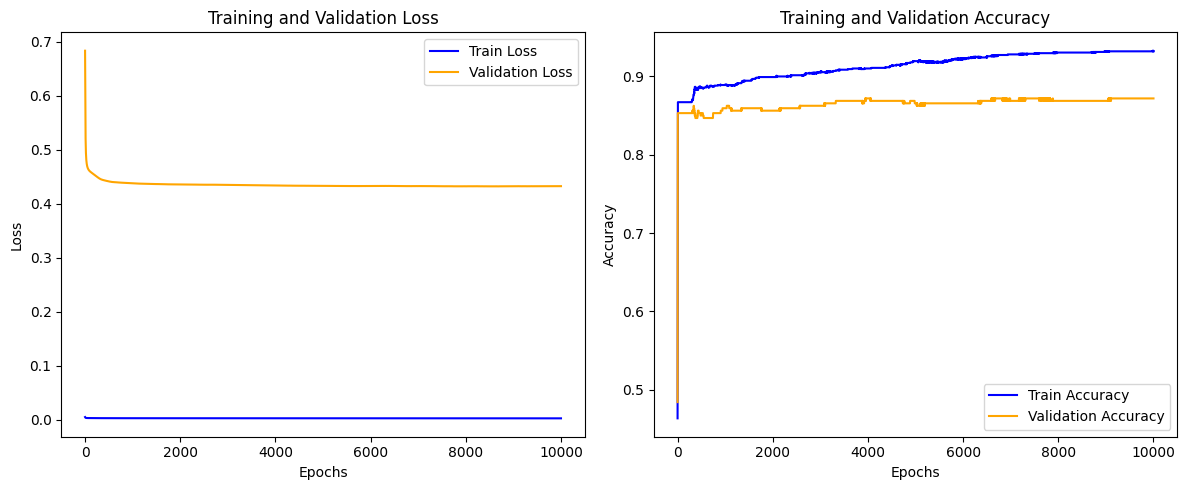

In [5]:
# Define the ANN model w/o Batch Normalization
class ANN_NonBatchNorm(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN_NonBatchNorm, self).__init__()

        # Define layers with Batch Normalization
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        # Forward pass with BatchNorm and ReLU activations
        x = torch.relu(self.fc1(x))
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x




# Instantiate the model (without batchnorm in intermediate layer)
input_dim = X_train.shape[1]  # Number of input features
output_dim = len(np.unique(y))  # Number of classes (wine quality classes)
model = ANN_NonBatchNorm(input_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)

# Implement the scheduler: ReduceLROnPlateau
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.9, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train_tensor.size(0))
    X_train_tensor = X_train_tensor[perm]
    y_train_tensor = y_train_tensor[perm]

    # Training in batches
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        # Get the batch
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(X_train_tensor)
    train_loss = avg_train_loss
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

        # Calculate validation accuracy
        _, val_predicted = torch.max(val_outputs, 1)
        correct_val = (val_predicted == y_test_tensor).sum().item()
        total_val = y_test_tensor.size(0)
        val_accuracy = correct_val / total_val

    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Step the scheduler with validation loss
    # scheduler.step(val_loss.item())

    # Print statistics every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [100/10000], Train Loss: 0.0033, Train Accuracy: 0.8968, Val Loss: 0.4359, Val Accuracy: 0.8656
Epoch [200/10000], Train Loss: 0.0032, Train Accuracy: 0.9007, Val Loss: 0.4264, Val Accuracy: 0.8844
Epoch [300/10000], Train Loss: 0.0032, Train Accuracy: 0.8999, Val Loss: 0.4240, Val Accuracy: 0.8844
Epoch [400/10000], Train Loss: 0.0032, Train Accuracy: 0.9109, Val Loss: 0.4223, Val Accuracy: 0.8875
Epoch [500/10000], Train Loss: 0.0031, Train Accuracy: 0.9187, Val Loss: 0.4224, Val Accuracy: 0.8812
Epoch [600/10000], Train Loss: 0.0031, Train Accuracy: 0.9203, Val Loss: 0.4210, Val Accuracy: 0.8844
Epoch [700/10000], Train Loss: 0.0031, Train Accuracy: 0.9210, Val Loss: 0.4231, Val Accuracy: 0.8844
Epoch [800/10000], Train Loss: 0.0031, Train Accuracy: 0.9218, Val Loss: 0.4243, Val Accuracy: 0.8844
Epoch [900/10000], Train Loss: 0.0031, Train Accuracy: 0.9234, Val Loss: 0.4280, Val Accuracy: 0.8719
Epoch [1000/10000], Train Loss: 0.0031, Train Accuracy: 0.9242, Val Loss: 0.4297, 

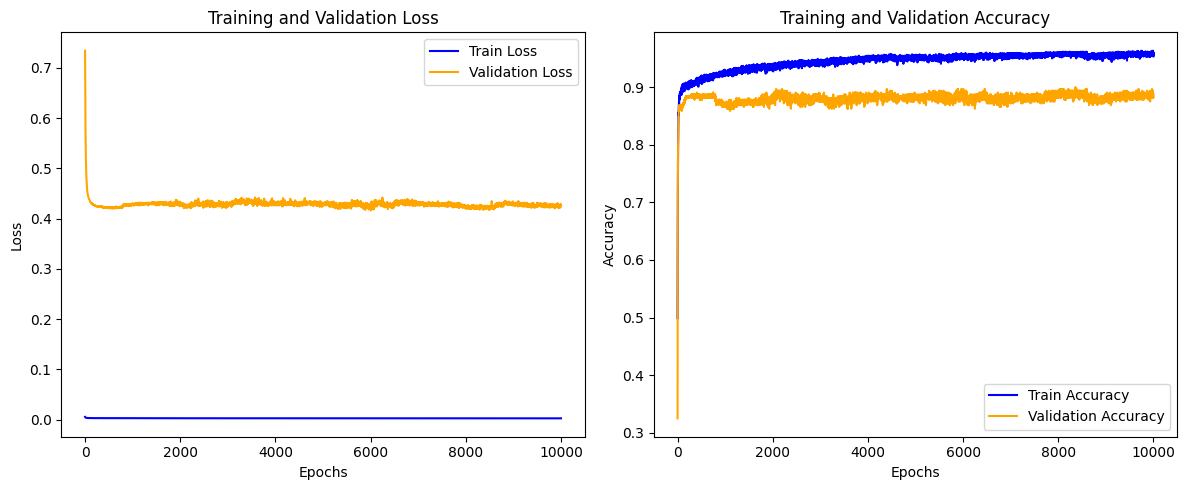

In [6]:
# @title ANNs with intermediate-level batchnorm layer
class ANNWithBatchNorm(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANNWithBatchNorm, self).__init__()

        # Define layers with Batch Normalization
        self.fc1 = nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        # Forward pass with BatchNorm and ReLU activations
        x = self.bn1(torch.relu(self.fc1(x)))  # BatchNorm after linear layer
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x

# Instantiate the model (with batchnorm in intermediate layer)
input_dim = X_train.shape[1]  # Number of input features
output_dim = len(np.unique(y))  # Number of classes (wine quality classes)
model = ANNWithBatchNorm(input_dim, output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)

# Implement the scheduler: ReduceLROnPlateau
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.9, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train_tensor.size(0))
    X_train_tensor = X_train_tensor[perm]
    y_train_tensor = y_train_tensor[perm]

    # Training in batches
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        # Get the batch
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(X_train_tensor)
    train_loss = avg_train_loss
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

        # Calculate validation accuracy
        _, val_predicted = torch.max(val_outputs, 1)
        correct_val = (val_predicted == y_test_tensor).sum().item()
        total_val = y_test_tensor.size(0)
        val_accuracy = correct_val / total_val

    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Step the scheduler with validation loss
    # scheduler.step(val_loss.item())

    # Print statistics every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [100/10000], Train Loss: 0.0035, Train Accuracy: 0.8710, Val Loss: 0.4499, Val Accuracy: 0.8562
Epoch [200/10000], Train Loss: 0.0033, Train Accuracy: 0.8819, Val Loss: 0.4447, Val Accuracy: 0.8625
Epoch [300/10000], Train Loss: 0.0034, Train Accuracy: 0.8749, Val Loss: 0.4448, Val Accuracy: 0.8656
Epoch [400/10000], Train Loss: 0.0033, Train Accuracy: 0.8819, Val Loss: 0.4435, Val Accuracy: 0.8625
Epoch [500/10000], Train Loss: 0.0033, Train Accuracy: 0.8819, Val Loss: 0.4458, Val Accuracy: 0.8531
Epoch [600/10000], Train Loss: 0.0033, Train Accuracy: 0.8851, Val Loss: 0.4458, Val Accuracy: 0.8531
Epoch [700/10000], Train Loss: 0.0033, Train Accuracy: 0.8898, Val Loss: 0.4447, Val Accuracy: 0.8531
Epoch [800/10000], Train Loss: 0.0033, Train Accuracy: 0.8835, Val Loss: 0.4446, Val Accuracy: 0.8656
Epoch [900/10000], Train Loss: 0.0033, Train Accuracy: 0.8858, Val Loss: 0.4467, Val Accuracy: 0.8594
Epoch [1000/10000], Train Loss: 0.0033, Train Accuracy: 0.8882, Val Loss: 0.4390, 

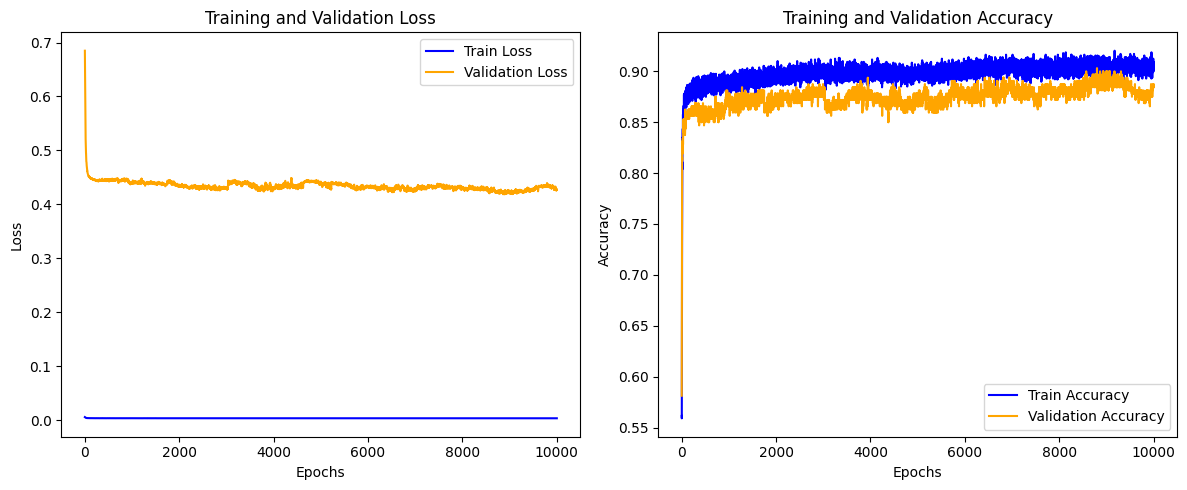

In [7]:
# @title ANNs with intermediate-level dropout (p=0.5) + batchnorm layer
class ANNWithBatchNorm_n_dropout(nn.Module):
    def __init__(self, input_dim, output_dim, p_dropout=0.5):
        super(ANNWithBatchNorm_n_dropout, self).__init__()

        # Define layers with Batch Normalization
        self.fc1 = nn.Linear(input_dim, 32)
        self.dropout = nn.Dropout(p_dropout)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, x):
        # Forward pass with BatchNorm and ReLU activations
        x = self.bn1(self.dropout(torch.relu(self.fc1(x))))  # BatchNorm after linear layer
        x = nn.Softmax(dim=1)(self.fc2(x))
        return x

# Instantiate the model (with batchnorm in intermediate layer)
input_dim = X_train.shape[1]  # Number of input features
output_dim = len(np.unique(y))  # Number of classes (wine quality classes)
model = ANNWithBatchNorm_n_dropout(input_dim, output_dim, p_dropout=0.5)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)

# Implement the scheduler: ReduceLROnPlateau
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.9, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train_tensor.size(0))
    X_train_tensor = X_train_tensor[perm]
    y_train_tensor = y_train_tensor[perm]

    # Training in batches
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        # Get the batch
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(X_train_tensor)
    train_loss = avg_train_loss
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

        # Calculate validation accuracy
        _, val_predicted = torch.max(val_outputs, 1)
        correct_val = (val_predicted == y_test_tensor).sum().item()
        total_val = y_test_tensor.size(0)
        val_accuracy = correct_val / total_val

    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Step the scheduler with validation loss
    # scheduler.step(val_loss.item())

    # Print statistics every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [100/10000], Train Loss: 0.0034, Train Accuracy: 0.8835, Val Loss: 0.4433, Val Accuracy: 0.8562
Epoch [200/10000], Train Loss: 0.0033, Train Accuracy: 0.8952, Val Loss: 0.4384, Val Accuracy: 0.8688
Epoch [300/10000], Train Loss: 0.0033, Train Accuracy: 0.8882, Val Loss: 0.4365, Val Accuracy: 0.8656
Epoch [400/10000], Train Loss: 0.0033, Train Accuracy: 0.8929, Val Loss: 0.4320, Val Accuracy: 0.8719
Epoch [500/10000], Train Loss: 0.0032, Train Accuracy: 0.8960, Val Loss: 0.4282, Val Accuracy: 0.8656
Epoch [600/10000], Train Loss: 0.0032, Train Accuracy: 0.8999, Val Loss: 0.4249, Val Accuracy: 0.8750
Epoch [700/10000], Train Loss: 0.0032, Train Accuracy: 0.9054, Val Loss: 0.4238, Val Accuracy: 0.8875
Epoch [800/10000], Train Loss: 0.0032, Train Accuracy: 0.9077, Val Loss: 0.4217, Val Accuracy: 0.8906
Epoch [900/10000], Train Loss: 0.0032, Train Accuracy: 0.9038, Val Loss: 0.4206, Val Accuracy: 0.8875
Epoch [1000/10000], Train Loss: 0.0032, Train Accuracy: 0.9085, Val Loss: 0.4220, 

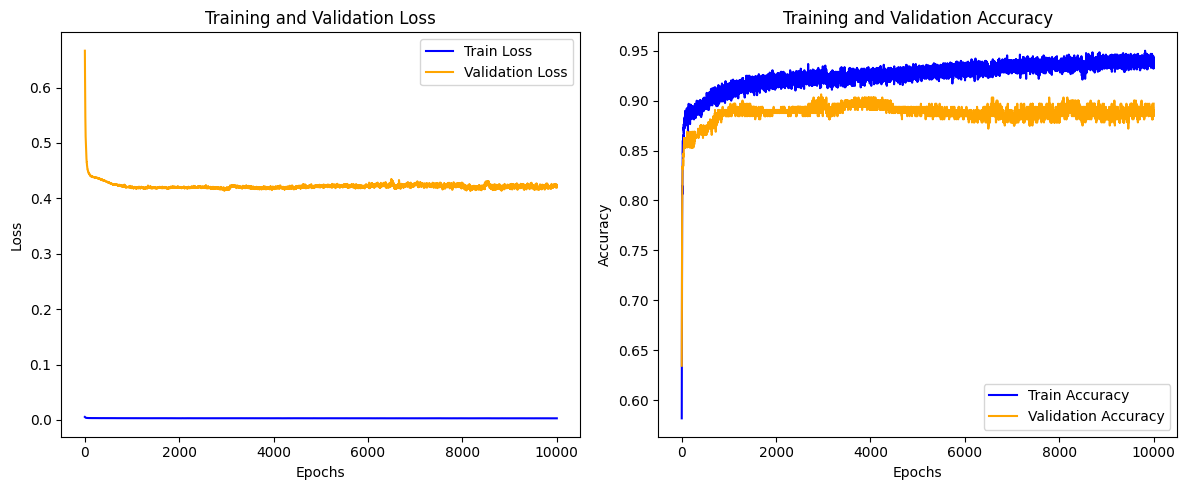

In [8]:
# @title ANNs with intermediate-level dropout (p=0.1) + batchnorm layer

# Instantiate the model (with batchnorm in intermediate layer)
input_dim = X_train.shape[1]  # Number of input features
output_dim = len(np.unique(y))  # Number of classes (wine quality classes)
model = ANNWithBatchNorm_n_dropout(input_dim, output_dim, p_dropout=0.1)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)

# Implement the scheduler: ReduceLROnPlateau
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.9, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train_tensor.size(0))
    X_train_tensor = X_train_tensor[perm]
    y_train_tensor = y_train_tensor[perm]

    # Training in batches
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        # Get the batch
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(X_train_tensor)
    train_loss = avg_train_loss
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

        # Calculate validation accuracy
        _, val_predicted = torch.max(val_outputs, 1)
        correct_val = (val_predicted == y_test_tensor).sum().item()
        total_val = y_test_tensor.size(0)
        val_accuracy = correct_val / total_val

    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Step the scheduler with validation loss
    # scheduler.step(val_loss.item())

    # Print statistics every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [100/10000], Train Loss: 0.0033, Train Accuracy: 0.8898, Val Loss: 0.4448, Val Accuracy: 0.8625
Epoch [200/10000], Train Loss: 0.0032, Train Accuracy: 0.9015, Val Loss: 0.4365, Val Accuracy: 0.8719
Epoch [300/10000], Train Loss: 0.0032, Train Accuracy: 0.9030, Val Loss: 0.4325, Val Accuracy: 0.8750
Epoch [400/10000], Train Loss: 0.0032, Train Accuracy: 0.9007, Val Loss: 0.4285, Val Accuracy: 0.8812
Epoch [500/10000], Train Loss: 0.0032, Train Accuracy: 0.9062, Val Loss: 0.4258, Val Accuracy: 0.8875
Epoch [600/10000], Train Loss: 0.0031, Train Accuracy: 0.9116, Val Loss: 0.4234, Val Accuracy: 0.8844
Epoch [700/10000], Train Loss: 0.0031, Train Accuracy: 0.9187, Val Loss: 0.4228, Val Accuracy: 0.8938
Epoch [800/10000], Train Loss: 0.0031, Train Accuracy: 0.9187, Val Loss: 0.4233, Val Accuracy: 0.8875
Epoch [900/10000], Train Loss: 0.0031, Train Accuracy: 0.9187, Val Loss: 0.4250, Val Accuracy: 0.8844
Epoch [1000/10000], Train Loss: 0.0031, Train Accuracy: 0.9218, Val Loss: 0.4254, 

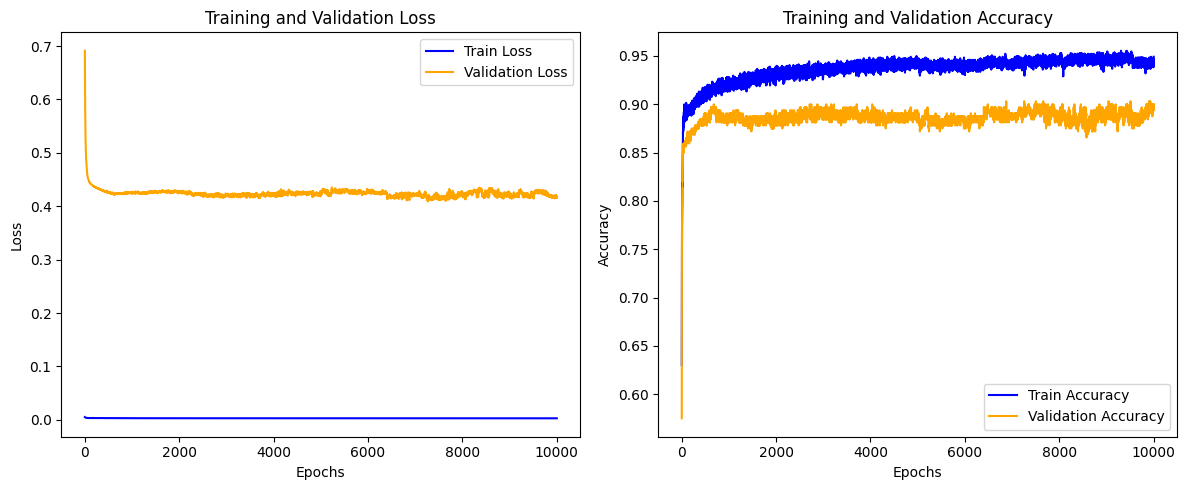

In [9]:
# @title ANNs with intermediate-level dropout (p=0.05) + batchnorm layer

# Instantiate the model (with batchnorm in intermediate layer)
input_dim = X_train.shape[1]  # Number of input features
output_dim = len(np.unique(y))  # Number of classes (wine quality classes)
model = ANNWithBatchNorm_n_dropout(input_dim, output_dim, p_dropout=0.05)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)

# Implement the scheduler: ReduceLROnPlateau
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.9, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    # Shuffle the training data
    perm = torch.randperm(X_train_tensor.size(0))
    X_train_tensor = X_train_tensor[perm]
    y_train_tensor = y_train_tensor[perm]

    # Training in batches
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        # Get the batch
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(X_train_tensor)
    train_loss = avg_train_loss
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

        # Calculate validation accuracy
        _, val_predicted = torch.max(val_outputs, 1)
        correct_val = (val_predicted == y_test_tensor).sum().item()
        total_val = y_test_tensor.size(0)
        val_accuracy = correct_val / total_val

    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)

    # Step the scheduler with validation loss
    # scheduler.step(val_loss.item())

    # Print statistics every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting the loss and accuracy curves
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
